# Rule-Based Triage Modeling and Evaluation

This notebook is the core of my Phase 1 analysis. Here, I will apply the rule-based labeling logic I've developed to the cleaned dataset of court rulings.

My goal is to transform the unstructured text into a structured, prioritized list by assigning a risk label (`high`, `medium`, `low`) to each document. This process uses simple, transparent rules to flag decisions that may contain procedural errors, unfair limitations on parties, or other issues that warrant further review.

## Why a Rule-Based Approach?

For this initial phase, I chose a rule-based system for two reasons:

* **Transparent for Legal Review**: Each flag can be traced back to the exact rule and phrase that triggered it, providing a clear and auditable trail for legal analysts.

* **Reliable for Known Legal Patterns**: This approach is especially effective in a legal context where specific phrases (e.g., “terminated parental rights”) are strong indicators of a case's significance.

## Notebook Objective & Plan

The goal of this notebook is to process the cleaned dataset and assign a final, evaluated priority flag to each document.

My process will follow these seven steps:

1. **Load and Explore Data**: I will load the cleaned DataFrame and the initial `v1` rule set.

2. **Apply Initial Model (V1)**: I will perform a first run of the Triage model to generate a baseline set of risk labels.

3. **Analyze Initial Results**: I will quantitatively and qualitatively analyze the baseline results to inform the refinement process.

4. **Final Model Run with Refined Rules**: After updating my rule set, I will re-run the entire pipeline to generate the final labels.

5. **Create Final Deliverable**: I will save the final, enriched dataset as the key output of this notebook.

6. **Model Performance Evaluation**: I will quantitatively evaluate the final model's performance against a human-labeled ground truth set.

7. **Conclusion & Next Steps**: I will summarize the project's findings and outline the strategic next steps.

In [1]:
# --- Standard Library Imports ---
import os
import re
import pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# --- Project Root Setup ---
# This block ensures the notebook's working directory is always the project root (compliance-nlp/).
# This makes all file paths for data and source code consistent and reproducible.
current_dir = Path.cwd()
if current_dir.name == 'notebooks':
    os.chdir(current_dir.parent)
    print(f"Changed working directory to project root: {os.getcwd()}")
else:
    print(f"Already at project root: {os.getcwd()}")

Changed working directory to project root: /Users/lidasmac/compliance-nlp


In [2]:
# --- Custom & Configuration Imports ---
# This cell can only run correctly after the working directory has been set above.
from config import DATA_DIR

# Import all the specific cleaning functions from my custom preprocessing module
from src.rule_based_labeling import (
    find_matched_phrases,
    find_highest_risk_label
)

# --- Pandas Display Options ---
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)

## Step 1: Load and Explore Data

In this step, I will load the two primary data sources for my analysis:

1.  **Cleaned Court Rulings:** The `party_and_decision_metadata.csv` file, which is the structured output from the previous notebook.
2.  **Initial Rule Set (v1):** The `labels_v1.csv` file. This is my baseline set of rules that I will use to generate the initial "v1" risk labels before any refinement.

In [3]:
# --- Load the cleaned data and the initial (v1) rule set ---

try:
    # 1. Define the correct paths using pathlib for robustness
    processed_dir = Path(DATA_DIR) / "processed"
    main_data_path = processed_dir / "party_and_decision_metadata.csv"
    labels_v1_path = Path(DATA_DIR) / "labels_v1.csv"

    # 2. Load the data from the specified paths
    df = pd.read_csv(main_data_path)
    labels_df_v1 = pd.read_csv(labels_v1_path)
    
    # 3. Provide an informative success message
    print("Data loaded successfully!")
    print(f"  - Rulings (df): {df.shape[0]} rows")
    print(f"  - V1 Rules (labels_df_v1): {labels_df_v1.shape[0]} rules")

except FileNotFoundError as e:
    print(f"Error: A required data file was not found.")
    print(f"   Details: {e}")
    print("\nPlease ensure you have run the previous notebooks and"
    "that the files are in the correct 'data/processed/' and 'data/' directories.")

Data loaded successfully!
  - Rulings (df): 74 rows
  - V1 Rules (labels_df_v1): 16 rules


### 1.1 Inspect the Main Dataset (`df`)

First, I will examine the main `df` DataFrame to understand its structure, confirm the data types, and check for any missing values before proceeding with the analysis.

In [4]:
# Get a concise summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   doc_index      74 non-null     int64 
 1   party_line     74 non-null     object
 2   decision_text  59 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.9+ KB


In [5]:
# Display the first few rows to see the data's format
df.head()

,doc_index,party_line,decision_text
0,0,"Bank of New York Mellon, etc., respondent, v Fenimore St. Realty, Inc., appellant, et al., defendants.","In an action to foreclose a mortgage, the defendant Fenimore St. Realty, Inc., appeals from an order of the Supreme Court, Kings County (Larry D. ..."
1,1,"Citimortgage, Inc., etc., respondent, v Yehudit Benyacob, etc., appellant, et al., defendants. Henry Kohn, Brooklyn, NY, for appellant.","In an action to foreclose a mortgage, the defendant Yehudit Benyacob appeals from an order of the Supreme Court, Kings County (Larry D. Martin, J...."
2,2,"853-855 McLean, LLC, respondent, v City of Yonkers, NY, et al., appellants.","In a proceeding pursuant to CPLR article 78 to review a determination of the City Council of the City of Yonkers, NY, dated December 11, 2018, den..."
3,3,"Edwin Delcid-Funez, appellant-respondent, v Seasons at East Meadow Home Owners Association, Inc., et al., respondents-appellants, et al., defendant.","In an action to recover damages for personal injuries, the plaintiff appeals, and the defendants Seasons at East Meadow Home Owners Association, I..."
4,4,"Kristin M. Cirillo, appellant, v Ronald Grullon, respondent. Kenneth M. Tuccillo, Hastings on Hudson, NY, for appellant. Steven A. Feldman, Manhas...","In a proceeding pursuant to Family Court Act article 6, the mother appeals from an order of the Family Court, Nassau County (Darlene D. Harris, J...."


The `.info()` output confirms that while we have 74 rows in total, the `decision_text` column only has 59 non-null values. This is the expected result from our previous notebook, where 15 documents failed the parsing step.

As a final data quality check, I will now run an explicit count of missing values to confirm this number precisely.

In [6]:
# Count null values in each column.
df.isnull().sum()

doc_index         0
party_line        0
decision_text    15
dtype: int64

### 1.2 Inspect the Initial Rule Set (`labels_df_v1`)

Next, I will perform a quick inspection of my initial `v1` rule set. This will confirm the number of rules I'm starting with and allow me to review the distribution of the `high`, `medium`, and `low` risk labels in my baseline version.

In [7]:
# Get a concise summary of the labels_df DataFrame
labels_df_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   phrase  16 non-null     object
 1   label   16 non-null     object
dtypes: object(2)
memory usage: 384.0+ bytes


In [8]:
# Display the first few rows to see a sample of the v1 rules
labels_df_v1.head()

,phrase,label
0,parental rights terminated,high
1,default judgment,high
2,appeal dismissed,medium
3,order affirmed,medium
4,judgment reversed,low


### 1.3 Analyze the Initial Rule Distribution

Next, I need to know how many rules I have for each risk level in my `v1` rule set. This is an important check to understand if my initial set of rules is balanced or skewed towards a particular category, which can influence the model's final output.

In [9]:
# Get the distribution of labels. Jupyter will auto-display the result.
labels_df_v1['label'].value_counts()

label
high      6
medium    6
low       4
Name: count, dtype: int64

### 1.4 Qualitative Review of Initial Rules

As a final step in my data exploration, I will perform a qualitative sanity check on the `v1` rule set. I will loop through each risk level and review a sample of the phrases associated with it.

This helps me confirm that my initial rules make intuitive sense before applying them in the model.

In [10]:
# Group by the label and show all phrases from each group
for label_name, group in labels_df_v1.groupby('label'):
    print(f"Risk Level: '{label_name}'")
    for phrase in group['phrase'].head():
        print(f"  - {phrase}")
    print("-" * 35)

Risk Level: 'high'
  - parental rights terminated
  - default judgment
  - conviction affirmed
  - custody transferred
  - suppressed evidence
-----------------------------------
Risk Level: 'low'
  - judgment reversed
  - conviction reversed
  - motion to dismiss granted
  - no appeal lies
-----------------------------------
Risk Level: 'medium'
  - appeal dismissed
  - order affirmed
  - remanded for further proceedings
  - motion to dismiss denied
  - best interests of the child
-----------------------------------


## Step 2: Apply Initial Model (V1)

With the data loaded and inspected, I will now run the initial "v1" of my Triage model. This involves two main actions: creating an efficient lookup dictionary from my rules, and then applying a phrase-matching function to find all relevant phrases in the documents.

### 2.1 Create the Initial Rule Dictionary

Before I can scan the documents, I need to convert my `labels_df_v1` DataFrame into a more efficient data structure for lookups.

I will create a Python dictionary where each key is a rule phrase and its value is the corresponding risk label (`high`, `medium`, `low`). Using a dictionary is much faster than repeatedly searching a DataFrame inside a loop.

To ensure consistent matching, I will convert all the phrases in the dictionary to lowercase, as my phrase-matching function is case-insensitive.

In [11]:
# --- Create the initial (v1) rules lookup dictionary ---
# I will create a dictionary from my v1 ruleset for efficient lookups.
# The phrases are converted to lowercase to ensure case-insensitive matching.

label_dict_v1 = dict(zip(labels_df_v1["phrase"].str.lower(), labels_df_v1["label"]))

print(f"Created the v1 rule dictionary with {len(label_dict_v1)} rules.")

Created the v1 rule dictionary with 16 rules.


### 2.2 Apply Initial Model (V1) - Phrase Matching

Now I will apply my rule-based matching engine to the cleaned dataset. Using the initial `v1` rule dictionary, I will scan each decision text and create a new `flag_phrases` column that lists all the rule phrases found in each document.

This is a critical step because this list of found phrases helps me understand why a ruling might be flagged and will be the direct input for the Triage model in the next step.

In [12]:
# --- Apply the phrase matching engine using the v1 rule set ---

# 1. (THE FIX) Ensure all values in the column are strings.
#    This explicitly replaces any NaN values with an empty string "" and reassigns the column.
df['decision_text'] = df['decision_text'].fillna("")

# 2. Apply the function to the cleaned column.
#    I'll create a new 'flag_phrases_v1' column containing a list of all
#    rule phrases found in each document.
df['flag_phrases_v1'] = df['decision_text'].apply(
    lambda text: find_matched_phrases(text, label_dict_v1)
)

print("Initial phrase matching complete. 'flag_phrases_v1' column added.")


# --- Verification Step: Inspect the new column ---
# I'll display the new column alongside the source text to verify the output.
display(df[['decision_text', 'flag_phrases_v1']].head(8))

Initial phrase matching complete. 'flag_phrases_v1' column added.


,decision_text,flag_phrases_v1
0,"In an action to foreclose a mortgage, the defendant Fenimore St. Realty, Inc., appeals from an order of the Supreme Court, Kings County (Larry D. ...",[]
1,"In an action to foreclose a mortgage, the defendant Yehudit Benyacob appeals from an order of the Supreme Court, Kings County (Larry D. Martin, J....",[]
2,"In a proceeding pursuant to CPLR article 78 to review a determination of the City Council of the City of Yonkers, NY, dated December 11, 2018, den...",[]
3,"In an action to recover damages for personal injuries, the plaintiff appeals, and the defendants Seasons at East Meadow Home Owners Association, I...",[]
4,"In a proceeding pursuant to Family Court Act article 6, the mother appeals from an order of the Family Court, Nassau County (Darlene D. Harris, J....",[]
5,"In an action to recover damages for negligence, the defendant appeals from an order of the Supreme Court, Kings County (Alexander M. Tisch, J.), d...",[]
6,"In an action, in effect, to recover damages for money had and received and unjust enrichment, the defendant appeals from a judgment of the Supreme...",[default judgment]
7,"Appeal by the defendant, as limited by his motion, from a sentence of the Supreme Court, Kings County (Joseph E. Gubbay, J., at plea; Matthew J. D...",[]


### 2.3 Apply Triage Model to Assign Risk Labels (V1)

My goal is to assign a single, definitive risk label to each document. For this, I will use a "Triage" approach: a document's final risk label will be determined by the most severe rule that it triggers. This allows me to quickly categorize all documents into clear buckets for review without requiring extensive tuning.

I will now apply my custom `find_highest_risk_label` function, which inspects the list of matched phrases and returns the single highest-ranking label found.

In [13]:
# --- Apply the Triage model using the v1 rule set ---
# I'll apply my custom 'find_highest_risk_label' function to the 'flag_phrases_v1'
# column to generate the initial risk labels.

df['risk_label_v1'] = df['flag_phrases_v1'].apply(
    lambda phrase_list: find_highest_risk_label(phrase_list, label_dict_v1)
)

print("Initial Triage labeling complete. 'risk_label_v1' column added.")


# --- Verification Step: Inspect the results ---
# I'll display the results to verify the output, focusing on the new label.
display(df[['flag_phrases_v1', 'risk_label_v1']].head(10))

Initial Triage labeling complete. 'risk_label_v1' column added.


,flag_phrases_v1,risk_label_v1
0,[],low
1,[],low
2,[],low
3,[],low
4,[],low
5,[],low
6,[default judgment],high
7,[],low
8,[best interests of the child],medium
9,[],low


## Step 3: Analyze Initial Results Quantitatively

Now that I have qualitatively inspected a sample of the results, I will perform a quantitative analysis.

My goal is to get a high-level overview of the model's baseline performance by counting how many documents were assigned to each risk category. This distribution is the primary result of my initial Triage model run and will serve as the "before" snapshot for my later comparison.

In [14]:
# This is the primary result of our triage model.
risk_buckets_v1 = df['risk_label_v1'].value_counts()
risk_buckets_v1

risk_label_v1
low       66
high       7
medium     1
Name: count, dtype: int64

### 3.1 Inspect High-Risk Documents

As a final sanity check, let's filter for the documents that were labeled `high` and inspect the phrases that were flagged within them. This confirms that our most important rules are working as expected.

#### A Note on My Refinement Strategy

For this first refinement cycle, I made a practical choice to focus my review only on the documents already flagged as`high`. My thinking was that these cases were the most likely place to quickly find other important key phrases.

I recognize this is a biased approach. A more comprehensive second round of refinement would need to analyze those specific "False Negatives" to make the model more thorough.

In [15]:
# --- 1. Filter the DataFrame to create a subset of only 'high' risk cases ---
high_risk_cases = df[df['risk_label_v1'] == 'high']

# --- 2. Display a sample of this subset, showing the most relevant columns ---
high_risk_cases[['decision_text', 'flag_phrases_v1', 'risk_label_v1']].head()

,decision_text,flag_phrases_v1,risk_label_v1
6,"In an action, in effect, to recover damages for money had and received and unjust enrichment, the defendant appeals from a judgment of the Supreme...",[default judgment],high
11,"In an action to foreclose a mortgage, the defendant Salvatore Pane appeals from an order and judgment of foreclosure and sale (one paper) of the S...",[default judgment],high
35,"Appeal by the defendant from a judgment of the County Court, Orange County (Craig S. Brown, J.), rendered May 16, 2023, convicting him of criminal...",[ineffective assistance of counsel],high
39,"Appeal by the defendant from a judgment of the County Court, Orange County (Craig S. Brown, J.), rendered May 16, 2023, convicting him of criminal...",[ineffective assistance of counsel],high
58,"In an action, inter alia, to recover damages for negligence, the plaintiff appeals from an order of the Supreme Court, Orange County (David S. Zuc...",[default judgment],high


### 3.2 Refinement: Analyzing Results and Improving the Rules

Now I will perform the important manual step. By manually reviewing the documents flagged by my initial model, I can validate my existing rules and discover new, high-impact phrases to make the system more intelligent.

#### Key Findings from My Review
My analysis of the initial high risk results was successful and yielded three key insights:

- **Validation of Existing Rules**: The review confirms that my core high risk rules are performing well. Phrases like `effective assistance of counsel` and `default judgment` consistently identified documents with significant procedural and fairness issues, validating my initial strategy.

- **Confirmation of Proposed Phrases**: The review confirmed that several phrases I considered adding are indeed high-value. I saw `immigration consequences`, `failure to state a cause of action`, and `special duty` appear in the flagged documents, proving they are worth adding to my rule set.

- **Discovery of New High-Impact Phrases**: Most importantly, the review uncovered several new phrases that are strong indicators of a noteworthy case but were not yet in my system.

Based on the findings above, the clear next step is to update my `labels.csv` file. The table below lists the new rules I will add to create a more robust and nuanced model.

| New Phrase to Add (as a Pattern) | Suggested Label | Rationale |
| :--- | :--- | :--- |
| **`waived (his\|her\|their) right to appeal`** | `high` | Catches all gender variations of this event in one rule. |
| **`violated (his\|her\|their) miranda rights`** | `high` | A fundamental constitutional challenge, now gender-neutral. |
| **`immigration consequences`** | `medium` | A critical factor in plea deals for non-citizens. |
| **`stop and frisk`** | `medium` | A key Fourth Amendment issue indicating a police procedure review. |
| **`unpreserved for appellate review`** | `medium` | An important procedural reason why a case's outcome was decided. |
| **`failure to state a cause of action`** | `medium` | A key reason for early-stage case dismissals. |

**ACTION: Manually Update `labels.csv`**

The next step is a manual one. I will now open the `data/labels.csv` file and add the new rules outlined in the table above, ensuring the regular expression patterns are correct. After saving the updated file, we will proceed with the cells below.

## Step 4: Final Model Run with Refined Rules

Based on my analysis in the previous step, I have created an improved rule set which I've saved as `labels.csv`.

I will now re-run the entire analysis pipeline using this new, larger rule set. This will allow me to directly measure the impact of my refinements and generate the final labels for the dataset.

### 4.1 Re-load Rules & Re-run Phrase Matching

First, I load the refined rule set and then re-run the phrase matching engine to create an updated list of flags for each document.

In [16]:
# Re-load the REFINED rules 
labels_df_final = pd.read_csv("data/labels.csv")
label_dict_final = dict(zip(labels_df_final["phrase"].str.lower(), labels_df_final["label"].str.lower()))
print(f"Success! The refined rule set now contains {len(label_dict_final)} rules.")

Success! The refined rule set now contains 22 rules.


### 4.2 Apply Final Triage Model

With the updated flags, we now apply our Triage function to assign the final risk label.

In [17]:
# Re-run the phrase matching with the NEW rules 
# This creates a new 'final_flag_phrases' column containing our refined results.
df['final_flag_phrases'] = df['decision_text'].apply(
    lambda text: find_matched_phrases(text, label_dict_final)
)

In [18]:
# --- Verification Step: Compare Flagged Phrases Before and After Refinement ---

# I will compare the 'v1' flags with the 'final' flags.
# First, I'll find the rows where the list of flagged phrases actually changed.
changed_flags_mask = df['flag_phrases_v1'].astype(str) != df['final_flag_phrases'].astype(str)
changed_flags_df = df[changed_flags_mask]

print("--- Inspecting Documents Affected by Rule Refinements ---")

if not changed_flags_df.empty:
    print(f"Found {len(changed_flags_df)} documents where the flagged phrases changed after refinement.")
    print("Displaying a sample:")
    
    # This view shows the direct impact of adding new rules.
    display(changed_flags_df[['flag_phrases_v1', 'final_flag_phrases']].head())
else:
    print("No documents had their list of flagged phrases changed by the new rules.")
    print("\nDisplaying a general sample of the final flags for review:")
    display(df[['flag_phrases_v1', 'final_flag_phrases']].head(10))

--- Inspecting Documents Affected by Rule Refinements ---
Found 15 documents where the flagged phrases changed after refinement.
Displaying a sample:


,flag_phrases_v1,final_flag_phrases
12,[],[failure to state a cause of action]
14,[],[unpreserved for appellate review]
16,[],[unpreserved for appellate review]
17,[],[failure to state a cause of action]
33,[],"[waived (his|her|their) right to appeal, unpreserved for appellate review]"


In [19]:
# Execute the FINAL Triage Analysis with the new rules 
# We apply our imported `find_highest_risk_label` function,
# passing it the new `label_dict_final`.
df['final_risk_label'] = df['final_flag_phrases'].apply(
    lambda phrase_list: find_highest_risk_label(phrase_list, label_dict_final)
)

# Display a sample to verify the new final column exists
df[['final_flag_phrases', 'risk_label_v1', 'final_risk_label']].head()

,final_flag_phrases,risk_label_v1,final_risk_label
0,[],low,low
1,[],low,low
2,[],low,low
3,[],low,low
4,[],low,low


### 4.3 Compare Before-and-After Results

By comparing the distribution of our initial run (`risk_label_v1`) with my final run (`final_risk_label`), I can see the direct impact of this update. I expect to see more documents categorized, especially in the `medium` and `high` buckets.

In [20]:
print("--- Initial Run Results (Before Refinement) ---")
display(df['risk_label_v1'].value_counts())

print("\n--- Final Run Results (After Refinement) ---")
display(df['final_risk_label'].value_counts())

--- Initial Run Results (Before Refinement) ---


risk_label_v1
low       66
high       7
medium     1
Name: count, dtype: int64


--- Final Run Results (After Refinement) ---


final_risk_label
low       55
medium    11
high       8
Name: count, dtype: int64

### 4.4 Interpretation of Final Results

The side-by-side comparison clearly demonstrates the success of my refinement cycle.

* **Successful Re-categorization:** The number of documents in the `low` risk category decreased by 11. These documents were successfully "upgraded" to more relevant risk categories.
* **High-Impact New Rules:** The `medium` risk category saw the most significant growth (from 1 to 11 cases), proving that my newly added `medium`-risk phrases were highly effective at identifying noteworthy cases that were previously missed. The `high` risk category also correctly identified one new case.

**Conclusion:** The manual refinement process was effective. It demonstrably improved the model's ability to correctly categorize documents, providing a more accurate set of labels for my final deliverable.

## Step 5: Create Final Deliverable

The comparison shows my refinements have successfully improved the model's coverage and classification. I am now ready to export my final, enriched dataset. This file is the main asset from this phase of the project and will be used for subsequent analysis and review.

In [21]:
# --- Select final columns and save the deliverable ---

# 1. Select the most useful columns for the final output.
#    Including both v1 and final labels is great for documenting the changes.
final_deliverable_df = df[[
    'doc_index',
    'decision_text',
    'risk_label_v1',      # The "before" label
    'final_flag_phrases', # The full list of flags from the refined run
    'final_risk_label'    # The "after" label
]].copy()

# 2. Define the output path within the 'processed' directory and save the file
output_dir = Path(DATA_DIR) / "processed"
os.makedirs(output_dir, exist_ok=True) # Ensure the directory exists
output_path = output_dir / "decisions_with_risk_labels.csv"

final_deliverable_df.to_csv(output_path, index=False)

print(f"Final deliverable successfully saved to: {output_path}")

# 3. Display a sample of the final saved data
print("\n--- Displaying a sample of the final deliverable ---")
display(final_deliverable_df.head())

Final deliverable successfully saved to: data/processed/decisions_with_risk_labels.csv

--- Displaying a sample of the final deliverable ---


,doc_index,decision_text,risk_label_v1,final_flag_phrases,final_risk_label
0,0,"In an action to foreclose a mortgage, the defendant Fenimore St. Realty, Inc., appeals from an order of the Supreme Court, Kings County (Larry D. ...",low,[],low
1,1,"In an action to foreclose a mortgage, the defendant Yehudit Benyacob appeals from an order of the Supreme Court, Kings County (Larry D. Martin, J....",low,[],low
2,2,"In a proceeding pursuant to CPLR article 78 to review a determination of the City Council of the City of Yonkers, NY, dated December 11, 2018, den...",low,[],low
3,3,"In an action to recover damages for personal injuries, the plaintiff appeals, and the defendants Seasons at East Meadow Home Owners Association, I...",low,[],low
4,4,"In a proceeding pursuant to Family Court Act article 6, the mother appeals from an order of the Family Court, Nassau County (Darlene D. Harris, J....",low,[],low


## Step 6: Model Performance Evaluation

With my `final_risk_label` generated by the model and my `human_label` prepared as a ground truth "answer key," I can now perform a final, quantitative evaluation. This will allow me to objectively measure how well my Triage model performed against my holistic, context-aware analysis.

### 6.1 Load and Merge Datasets

First, I will load both my model's final output and my ground truth file, then merge them together on their common ID.

In [22]:
# --- Load and Merge Datasets for Evaluation ---

try:
    # 1. Define the correct paths using pathlib for robustness
    processed_dir = Path(DATA_DIR) / "processed"
    model_results_path = processed_dir / "decisions_with_risk_labels.csv"
    ground_truth_path = Path(DATA_DIR) / "ground_truth_labels.csv"

    # 2. Load the data from the specified paths
    model_results_df = pd.read_csv(model_results_path)
    ground_truth_df = pd.read_csv(ground_truth_path)

    # 3. Merge the two DataFrames to align model predictions with human labels
    #    The 'doc_index' column is the key for joining them.
    eval_df = pd.merge(model_results_df, ground_truth_df, on='doc_index')

    # 4. Verification: Display a sample of the merged evaluation data
    print("Data loaded and merged successfully.")
    display(eval_df[['doc_index', 'human_label', 'final_risk_label']].head())

except FileNotFoundError as e:
    print(f"Error: A required data file was not found.")
    print(f"   Details: {e}")
    print("\nPlease ensure all necessary CSV files exist in the 'data/processed/' and 'data/' directories.")

Data loaded and merged successfully.


,doc_index,human_label,final_risk_label
0,0,high,low
1,1,high,low
2,2,low,low
3,3,medium,low
4,4,medium,low


### A Note on Evaluation Strategy

In a real-world scenario with thousands of documents, the dataset would likely be highly imbalanced (e.g., many `low` risk cases and very few `high` risk cases). In that situation, the best practice for creating a ground truth set is **stratified sampling**. This would involve taking a random sample from each predicted category (`high`, `medium`, `low`) to ensure that the rare but critical `high` risk cases are properly represented in the evaluation.

However, since my dataset for this project is a manageable 59 documents, I can perform a **full population review**. This is a more robust approach for this specific project, as it allows me to create a complete ground truth "answer key" and measure my model's exact performance without any sampling error.

The following evaluation is therefore based on a ground truth set covering 100% of the data.

### 6.2 Confusion Matrix

A confusion matrix is the best way for me to visualize the performance of my classification model. It shows exactly where the model was correct and where it was "confused."

* The **rows** will represent the **True Label** (from my manual review).
* The **columns** will represent the **Model's Prediction**.
* The diagonal from top-left to bottom-right shows all the correct predictions.

--- Confusion Matrix ---


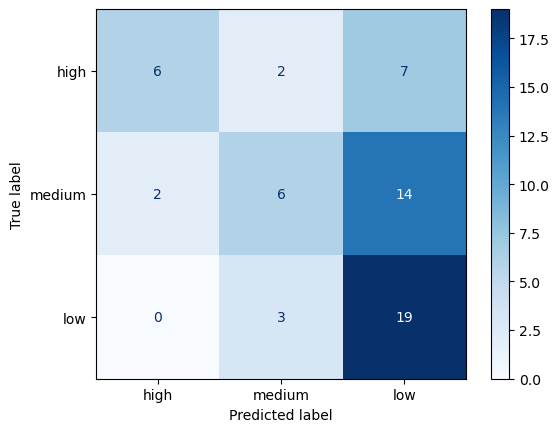

In [50]:
# Define the "true" answers and the model's "predicted" answers
y_true = eval_df['human_label']
y_pred = eval_df['final_risk_label']

# Define the order of your labels for the matrix axes so it's easy to read
labels = ['high', 'medium', 'low']

# Generate and display the matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

print("--- Confusion Matrix ---")
disp.plot(cmap=plt.cm.Blues)
plt.show()

### 6.3 Precision & Recall Report

From the confusion matrix, I can calculate the key performance metrics. The `classification_report` from scikit-learn does this for us automatically.

* **Precision:** "When the model predicted `high`, how often was it right?" (Measures reliability)
* **Recall:** "Of all the cases that were truly `high`, how many did the model find?" (Measures completeness)
* **F1-Score:** A weighted average of Precision and Recall, providing a single score for performance.

In [52]:
# Use the same variables and labels from the previous step
print("--- Classification Report ---")
print(classification_report(y_true, y_pred, labels=labels))

--- Classification Report ---
              precision    recall  f1-score   support

        high       0.75      0.40      0.52        15
      medium       0.55      0.27      0.36        22
         low       0.47      0.86      0.61        22

    accuracy                           0.53        59
   macro avg       0.59      0.51      0.50        59
weighted avg       0.57      0.53      0.50        59



## Step 7: Conclusion & Next Steps

This notebook successfully developed, refined, and evaluated a rule-based Triage model. The process validated that a rules-based approach can effectively flag high-risk legal documents and provided a quantitative baseline for its performance.

### Final Performance Evaluation

The quantitative evaluation provides a clear performance baseline for the model and validates the project's strategic approach. The key findings are for the **`high` risk category**, which is the most critical for any compliance review.

* **Key Strength (Precision): 75% for `high` risk cases.**
    * This indicates that when the model flags a case as high priority, the flag is reliable and warrants attention.

* **Area for Improvement (Recall): 40% for `high` risk cases.**
    * This result was expected due to my targeted refinement strategy. It confirms the model is not yet comprehensive and provides a clear, data-driven justification for moving to Phase 2, where the primary goal will be to use more advanced techniques to improve recall.
### Next Steps Justified by This Analysis

The results of this evaluation provide a clear, data-driven mandate for the next phase of the project:

1.  **Address Recall with Semantic Search:** The top priority is to use more advanced NLP techniques to find the cases that the current rule set misses. I will implement a semantic search pipeline using SBERT and FAISS to find conceptually similar documents, directly addressing the low recall.
2.  **Benchmark Against Advanced Methods:** Using the `ground_truth_labels.csv` file as a high-quality evaluation set, I will benchmark the rule-based model against an LLM-based classifier (using a RAG approach) to objectively compare the two methods.